In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [9]:
datafile = 'ex4/ex4data1.mat'
data = sio.loadmat(datafile)
# Features and labels
X, Y = data['X'], data['y']
# Store number of training examples
m = len(Y)

print Y.shape
print X.shape

(5000, 1)
(5000, 400)


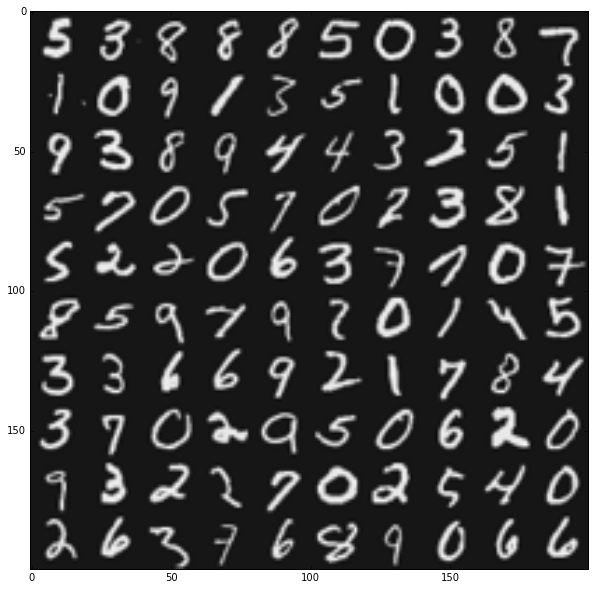

In [10]:
import random
import scipy.misc

# Compute number of items to display
display_rows, display_cols = 10, 10

total_digits = display_rows * display_cols

# Compute the size of each item to be displayed
example_height, example_width = 20, 20

# Get random indices to be displayed.
# random.sample(population,k) 
# where k is the number of items to select from the population
rows_to_display = random.sample(range(X.shape[0]),total_digits)

# Create initial picture by multiplying
# the number of rows to be displayed + the height of one digit
# and the nubmer of cols to be displayed + the width of one digit
picture = np.zeros((display_rows * example_height, display_cols * example_width))

curr_row, curr_col = 0, 0
for row in rows_to_display:
    if curr_col == display_cols:
        curr_col = 0
        curr_row += 1
    
    # Get digit image from 400x1 row. (Transform to 20x20)
    curr_digit = X[row].reshape(example_height, example_width).T
    
    # Row and col to be replaced with digit
    modified_row = curr_row * example_height
    modified_col = curr_col * example_width
    
    # Get specific and replace
    picture[modified_row:modified_row + curr_digit.shape[0],modified_col:modified_col + curr_digit.shape[1]] = curr_digit
    curr_col += 1

# Display image
image = scipy.misc.toimage(picture)
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')